# Medical Cost Prediction: A Regression Analysis
##### The goal is to understand the factors that influence medical costs and to build a model that can predict a person's insurance charges
##### Medical Cost Personal Datasets on Kaggle: https://www.kaggle.com/datasets/mirichoi0218/insurance

### 1. Exploratory data analysis 

In [1]:
# installing seaborn library on Jupyterlite
%pip install seaborn

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

Matplotlib is building the font cache; this may take a moment.


In [3]:
# data loading process
data = pd.read_csv("insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# examine the size of the dataset
data.shape

(1338, 7)

In [5]:
# checking Null values
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
# checking data types of each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 57.6+ KB


### 1.1 Checking for outliers 

In [7]:
# examine descriptive statistics of the dataset, checking for outliers
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


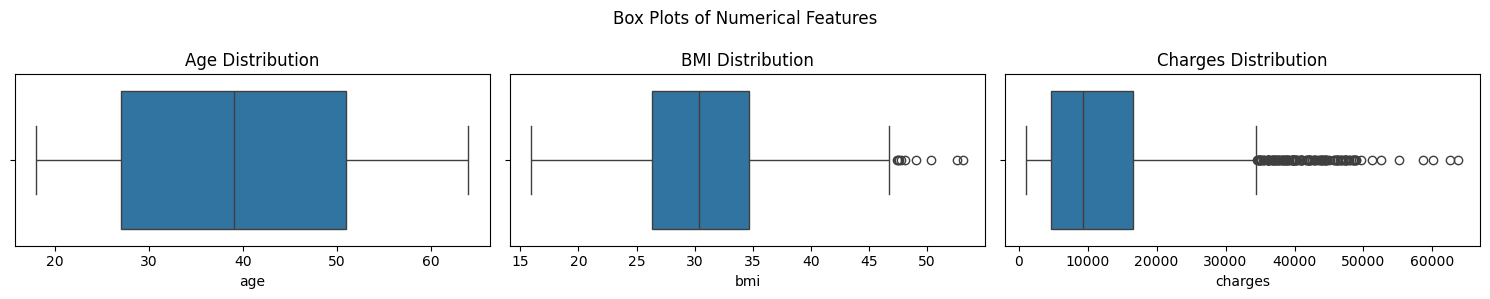

In [8]:
# Create box plots for numerical columns to visually inspect for outliers
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
fig.suptitle('Box Plots of Numerical Features')

sns.boxplot(ax=axes[0], x=data['age'])
axes[0].set_title('Age Distribution')

sns.boxplot(ax=axes[1], x=data['bmi'])
axes[1].set_title('BMI Distribution')

sns.boxplot(ax=axes[2], x=data['charges'])
axes[2].set_title('Charges Distribution')

plt.tight_layout()
plt.show()

In [9]:
# quanitfyig outliers using IQR method for numeric columns

def find_outlier_iqr(df, column, iqr_factor):

    """ 
        Find outliers using IQR method
        df (pandas.Dataframe): dataframe of interest
        column (string): the name of column of interest in df
        iqr_factor (float): The multiplier for the IQR to define outlier bounds, standard is 1.5

        returns a dataframe with outlier rows      
    """
    # define iqr
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1     

    # define upper_limit
    upper_limit = q3 + (iqr * iqr_factor)
    lower_limit = q1 - (iqr * iqr_factor)

    # define outliers
    outliers = df[(df[column] > upper_limit) | (df[column] < lower_limit)]
    
    # return a dataframe with outlier rows
    return outliers

In [10]:
# find outliers of bmi
bmi_outliers = find_outlier_iqr(data, 'bmi', 1.5)
bmi_outliers

,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801
847,23,male,50.38,1,no,southeast,2438.05520
860,37,female,47.60,2,yes,southwest,46113.51100
1047,22,male,52.58,1,yes,southeast,44501.39820
1088,52,male,47.74,1,no,southeast,9748.91060
1317,18,male,53.13,0,no,southeast,1163.46270


In [11]:
# find outliers of charges
charges_outliers = find_outlier_iqr(data, 'charges', 1.5)
charges_outliers

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309
1301,62,male,30.875,3,yes,northwest,46718.16325
1303,43,male,27.800,0,yes,southwest,37829.72420
1313,19,female,34.700,2,yes,southwest,36397.57600


In [12]:
print(charges_outliers[charges_outliers['smoker'] == 'yes']['smoker'].count())

136


Note:

The analysis confirms a powerful insight: 98% of the high-cost outliers (136 out of 139) are smokers.
This result strongly indicates that the high charges are not random data errors but are real-world costs systematically linked to a key feature (smoking). Therefore, these outliers represent valuable information and will be retained for modeling."

### 2. Hypothesis testing 

##### "Do smokers have significantly higher medical charges than non-smokers?"
##### Null Hypothesis (H0): there is no significant differnece of medical charges between smokers and non-smokers 
##### Alternative Hypothesis (Ha): there is  significant differnece of medical charges between smokers and non-smokers 

In [13]:
# create subset of smokers and non-smokers for further t-test
data_smoker = data[data["smoker"] == "yes"]
data_non_smoker = data[data["smoker"] == "no"]

# randomly select 50 samples from subsets of smokers 
sample_smoker = data_smoker.sample(n = 50, replace = True, random_state = 42)

# randomly select 50 samples from subsets non-smokers
sample_non_smoker = data_non_smoker.sample(n = 50, replace = True, random_state = 42)

# perform two-tail t-test with significance level = 0.05
stats.ttest_ind(a = sample_smoker['charges'], b = sample_non_smoker['charges'], equal_var = False)

TtestResult(statistic=np.float64(11.66139328875225), pvalue=np.float64(5.5421788017767765e-18), df=np.float64(69.09513639619166))

##### Note:

Since the p value (5.5421788017767765e-18) is << significance level (0.05), we reject H0, meaning the the charges between smokers and non-smokers shows significant difference

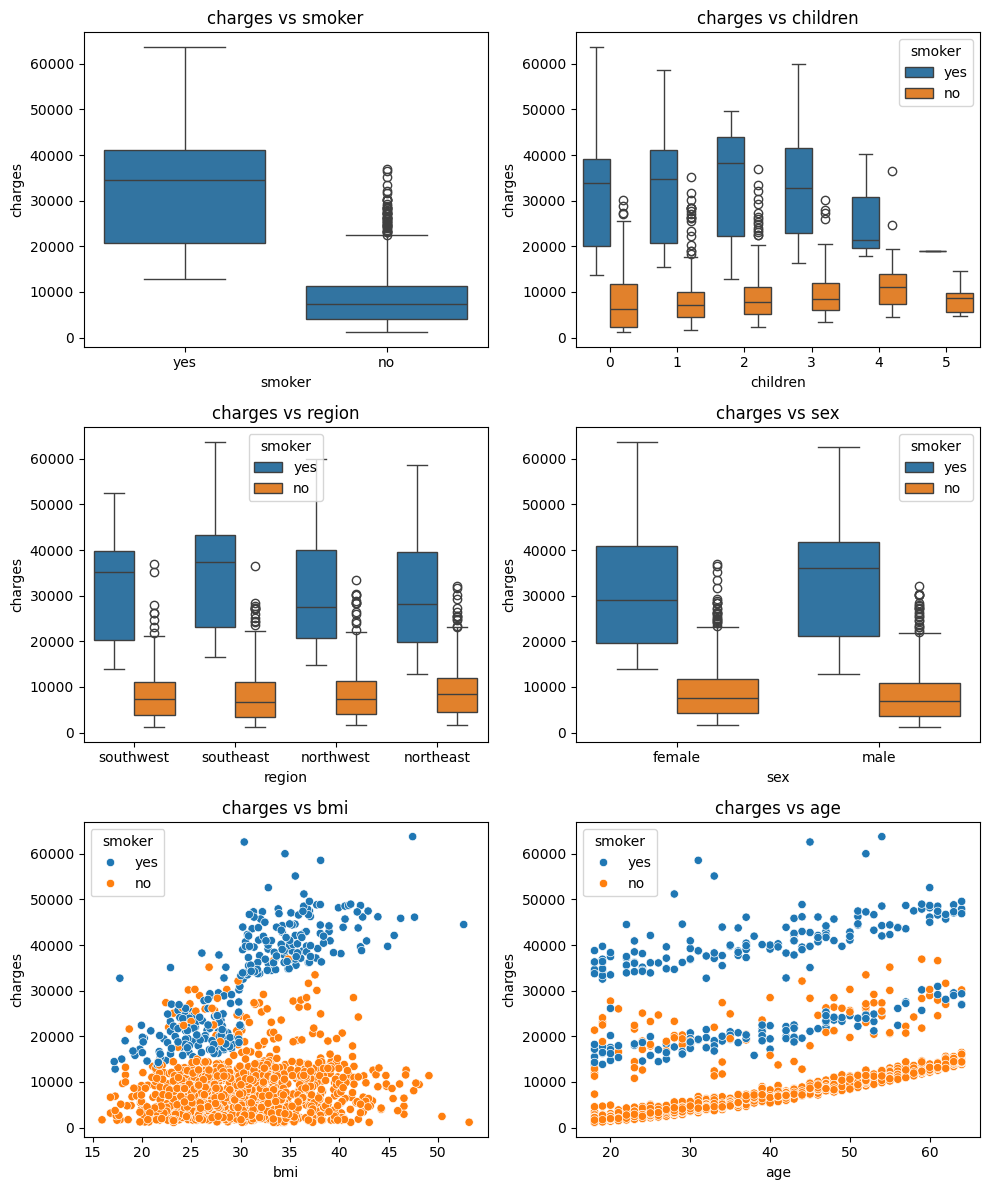

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

sns.boxplot(x = 'smoker', y = 'charges', data = data, ax=axes[0, 0])
axes[0, 0].set_title("charges vs smoker")

sns.boxplot(x = 'children', y = 'charges', hue = 'smoker', data = data, ax=axes[0, 1])
axes[0, 1].set_title("charges vs children")

sns.boxplot(x = 'region', y = 'charges', hue = 'smoker', data = data, ax=axes[1, 0])
axes[1, 0].set_title("charges vs region")

sns.boxplot(x = 'sex', y = 'charges', hue = 'smoker', data = data, ax=axes[1, 1])
axes[1, 1].set_title("charges vs sex")

sns.scatterplot(x = 'bmi', y = 'charges', hue = 'smoker', data = data, ax=axes[2, 0])
axes[2, 0].set_title("charges vs bmi")

sns.scatterplot(x = 'age', y = 'charges', hue = 'smoker', data = data, ax=axes[2, 1])
axes[2, 1].set_title("charges vs age")

plt.tight_layout()
plt.show()

#####  Note:

The distribution of the above plots further confirmed the result of the two-tail t-test which shows significant charges differences between 
smokers and non-smokers as can be observed when plotting charges agianst other independent variables, emerging subgroups are due to smoker category

### 3. Predictive Modeling  - using full model as baseline reference

##### Examine the relationship between each independent variable with charges and establish a multiple linear regression model

##### (1) Multiple linear regression

In [15]:
# building a multiple linear regression model
ols_formula = "charges ~ age + bmi + C(smoker) + C(sex) + C(region) + C(children)"
model = ols(formula = ols_formula, data = data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     334.7
Date:                Wed, 09 Jul 2025   Prob (F-statistic):               0.00
Time:                        10:12:48   Log-Likelihood:                -13545.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1325   BIC:                         2.718e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.193e+04    993.657    -12.003      0.000   -1.39e+04   -9977.861
C(smoker)[T.yes]        2.384e+04    414.139     57.557      0.000     2.3e+04    2.46e+04
C(sex)[T.male]          -128.1616    332.834     -0.385      0.700    -781.101     524.778
C(region)[T.northwest]  -380.0439    476.559     -0.797      0.425   -1314.936     554.848
C(region)[T.southeast] -1033.1375    479.139     -2.156      0.031   -1973.091     -93.184
C(region)[T.southwest]  -952.8878    478.153     -1.993      0.046   -1890.908     -14.867
C(children)[T.1]         390.9782    421.350      0.928      0.354    -435.608    1217.565
C(children)[T.2]        1635.7772    466.670      3.505      0.000     720.284    2551.270
C(children)[T.3]         964.3403    548.097      1.759      0.079    -110.893    2039.574
C(children)[T.4]        2947.3680   1239.163      2.379      0.018     516.432    5378.304
C(children)[T.5]        1116.0395   1456.015      0.767      0.444   -1740.307    3972.386
age                      257.1933     11.914     21.587      0.000     233.820     280.567
bmi                      336.9088     28.612     11.775      0.000     280.779     393.039
==============================================================================
Omnibus:                      293.990   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              695.789
Skew:                           1.191   Prob(JB):                    8.15e-152
Kurtosis:                       5.609   Cond. No.                         453.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Note:

(1) Smoker is the primary contributing factor of medical cost, smoker increase charges by an average of $23840 compared to non-smoker

(2) Age: for each additional year of age, medical charges increase by an average of $257, holding other factors constant. This is also a highly significant predictor (p < 0.001) 

(3) BMI: For each additional unit of BMI, medical charges increase by an average of $336, holding other factors constant. This relationship is highly statistically significant (p < 0.001)

(4) Children: having 4 children is associated with an increase in charges of about $2,947 compared to having no children, and this is statistically significant (p = 0.018). The effects for other numbers of children are not statistically significant at the conventional 5% level.

(5) Sex: sex is not a statistically significant indicator (p = 0.07)

(6) Region: living in the Southeast or Southwest is associated with lower charges compared to the reference region (Northeast). The Southwest region shows a statistically significant decrease of about 953 dollers (p = 0.046), and the Southeast shows a decrease of 1,033 dollars (p = 0.031). The Northwest region does not show a statistically significant difference.

### 3.1 Model Diagnostics

Examine normality of residue and its variance

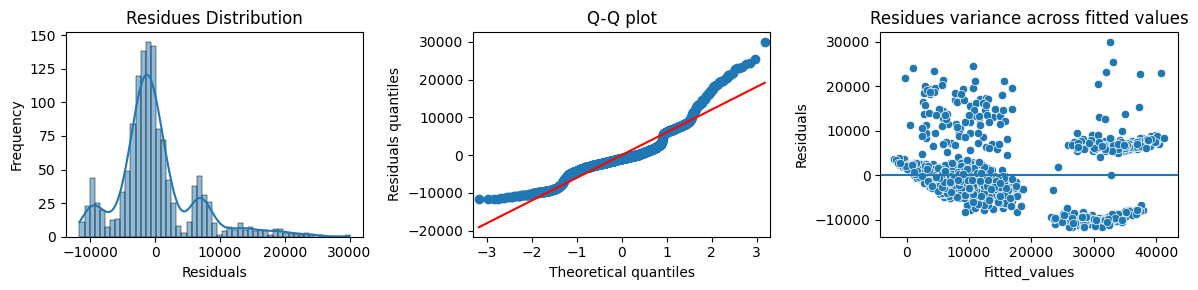

In [16]:
# assess residues from the model
residues = model.resid
fitted_values = model.fittedvalues

fig, axes = plt.subplots(1, 3, figsize=(12, 3)) # Increased width for side-by-side

# use histogram to visualize distribution of residues - Residuals Normality
sns.histplot(x=residues,  kde=True, ax=axes[0])
axes[0].set_title("Residues Distribution")
axes[0].set_xlabel("Residuals")
axes[0].set_ylabel("Frequency")

# use Q-Q plot to visualize distribution of residues - Residuals Normality
sm.qqplot(residues, line = 's', ax=axes[1])
axes[1].set_title("Q-Q plot")
axes[1].set_xlabel("Theoretical quantiles")
axes[1].set_ylabel("Residuals quantiles")

# use scatterplot to visualize variance of residue across fitted_values - Residuals Homoscedasticity
sns.scatterplot(x = fitted_values, y=residues, ax=axes[2])
axes[2].set_title("Residues variance across fitted values")
axes[2].set_xlabel("Fitted_values")
axes[2].set_ylabel("Residuals")
axes[2].axhline(0)

plt.tight_layout()
plt.show()

Note:

After assessing the validity of the model, the result is as follow:

(1) Violation of Normality: The "Residues Distribution" histogram is heavily right-skewed, and the "Q-Q plot" confirms this, with the points curving significantly away from the diagonal line, especially at the higher end.

(2) Violation of Homoscedasticity: The "Residues variance across fitted values" plot shows a classic funnel shape. The spread of the residuals increases as the predicted charge value gets higher. This is a clear sign of heteroscedasticity.

### 3.2 Address Assumption Violations with a Log Transformation

(1) Apply a logarithmic transformation to 'charges'

In [17]:
# use numpy to make a logorithm of charge
data["log_charges"] = np.log(data['charges'])
data.head()

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176
1,18,male,33.770,1,no,southeast,1725.55230,7.453302
2,28,male,33.000,3,no,southeast,4449.46200,8.400538
3,33,male,22.705,0,no,northwest,21984.47061,9.998092
4,32,male,28.880,0,no,northwest,3866.85520,8.260197


(2) Rebuild the model by using log_charge

In [18]:
# building a new model using log_charges as dependent variable
ols_formula_log = "log_charges ~ age + bmi + children + C(sex) + C(smoker) +C(region)"
model_log = ols(formula = ols_formula_log, data=data).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_charges   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     549.8
Date:                Wed, 09 Jul 2025   Prob (F-statistic):               0.00
Time:                        10:12:49   Log-Likelihood:                -808.52
No. Observations:                1338   AIC:                             1635.
Df Residuals:                    1329   BIC:                             1682.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7.0306      0.072     97.112      0.000       6.889       7.173
C(sex)[T.male]            -0.0754      0.024     -3.091      0.002      -0.123      -0.028
C(smoker)[T.yes]           1.5543      0.030     51.333      0.000       1.495       1.614
C(region)[T.northwest]    -0.0638      0.035     -1.827      0.068      -0.132       0.005
C(region)[T.southeast]    -0.1572      0.035     -4.481      0.000      -0.226      -0.088
C(region)[T.southwest]    -0.1290      0.035     -3.681      0.000      -0.198      -0.060
age                        0.0346      0.001     39.655      0.000       0.033       0.036
bmi                        0.0134      0.002      6.381      0.000       0.009       0.017
children                   0.1019      0.010     10.085      0.000       0.082       0.122
==============================================================================
Omnibus:                      463.882   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1673.760
Skew:                           1.679   Prob(JB):                         0.00
Kurtosis:                       7.330   Cond. No.                         311.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3.3 Model Diagnostics of newmodel -  model_log

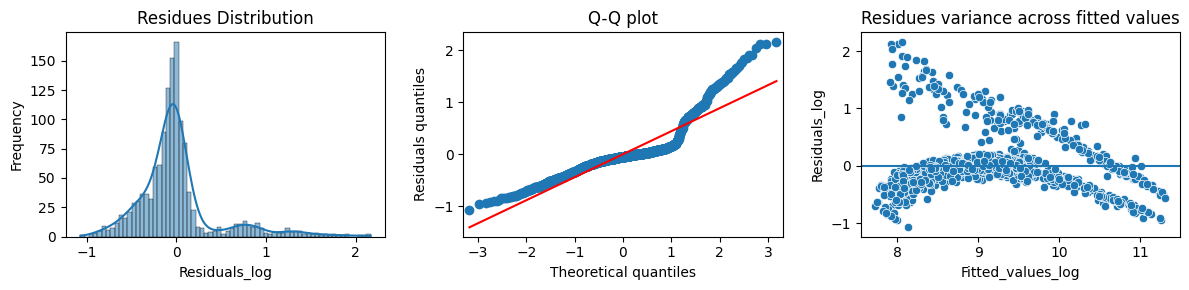

In [19]:
# assess residues from the model
residues_log = model_log.resid
fitted_values_log = model_log.fittedvalues

fig, axes = plt.subplots(1, 3, figsize=(12, 3)) # Increased width for side-by-side

# use histogram to visualize distribution of residues - Residuals Normality
sns.histplot(x=residues_log, kde=True, ax=axes[0])
axes[0].set_title("Residues Distribution")
axes[0].set_xlabel("Residuals_log")
axes[0].set_ylabel("Frequency")

# use Q-Q plot to visualize distribution of residues - Residuals Normality
sm.qqplot(residues_log, line = 's', ax=axes[1])
axes[1].set_title("Q-Q plot")
axes[1].set_xlabel("Theoretical quantiles")
axes[1].set_ylabel("Residuals quantiles")

# use scatterplot to visualize variance of residue across fitted_values - Residuals Homoscedasticity
sns.scatterplot(x = fitted_values_log, y=residues_log, ax=axes[2])
axes[2].set_title("Residues variance across fitted values")
axes[2].set_xlabel("Fitted_values_log")
axes[2].set_ylabel("Residuals_log")
axes[2].axhline(0)

plt.tight_layout()
plt.show()

Note:

(1) Residues Distribution & Q-Q Plot (Normality): While not a perfect bell curve, the histogram is now much more symmetrical and centered around zero. Most importantly, the Q-Q plot shows the points hugging the diagonal red line very closely. This indicates that the normality assumption is now reasonably met.

(2) Residues variance across fitted values (Homoscedasticity): The distinct "funnel shape" is gone. The points are now scattered much more randomly and evenly across the horizontal line. heteroscedasticity corrected sucessfully.

(3) However, the slight curve suggests there might be a non-linear relationship between one of the predictors and the log_charges that the current linear model isn't fully capturing.

### 3.4 Addressing the interaction term

Although the log transformation has successfully fixed the major assumption violations (normality and homoscedasticity), our initial exploratory data analysis revealed a crucial insight that the current model does not yet capture.

The scatterplot of bmi vs. the original charges showed a clear and dramatic difference in the cost trend for smokers versus non-smokers. The effect of BMI on healthcare costs was much more severe for smokers. This suggests a strong interaction effect between these two variables.

Therefore, the most logical next step in refining the model is to first incorporate this interaction term (bmi * smoker). 

In [20]:
# building a new model by incorporating interaction term
ols_formula_interaction = "log_charges ~ age + children + C(sex) + C(region) + bmi * C(smoker)"
model_interaction = ols(formula = ols_formula_interaction, data=data).fit()
model_interaction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_charges   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     534.0
Date:                Wed, 09 Jul 2025   Prob (F-statistic):               0.00
Time:                        10:12:49   Log-Likelihood:                -762.05
No. Observations:                1338   AIC:                             1544.
Df Residuals:                    1328   BIC:                             1596.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7.3374      0.077     95.697      0.000       7.187       7.488
C(sex)[T.male]            -0.0871      0.024     -3.688      0.000      -0.133      -0.041
C(region)[T.northwest]    -0.0711      0.034     -2.108      0.035      -0.137      -0.005
C(region)[T.southeast]    -0.1627      0.034     -4.800      0.000      -0.229      -0.096
C(region)[T.southwest]    -0.1375      0.034     -4.062      0.000      -0.204      -0.071
C(smoker)[T.yes]           0.1564      0.146      1.071      0.284      -0.130       0.443
age                        0.0348      0.001     41.281      0.000       0.033       0.036
children                   0.1031      0.010     10.569      0.000       0.084       0.122
bmi                        0.0034      0.002      1.502      0.133      -0.001       0.008
bmi:C(smoker)[T.yes]       0.0456      0.005      9.773      0.000       0.036       0.055
==============================================================================
Omnibus:                      520.045   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2150.321
Skew:                           1.846   Prob(JB):                         0.00
Kurtosis:                       7.994   Cond. No.                         663.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note:

(1) The new interaction term, bmi:C(smoker)[T.yes], is highly significant (p-value = 0.000)

(2) For a non-smoker, the effect of an extra BMI point is given by the bmi coefficient (0.0034), which is not statistically different from zero.

(3) For a smoker, the effect of an extra BMI point is the sum of the bmi coefficient and the interaction term coefficient (0.0034 + 0.0456 = 0.049). This means for each one-unit increase in BMI, a smoker's charges increase by approximately 4.9%.

### 3.5 Model Diagnostics of newmodel -  model_log

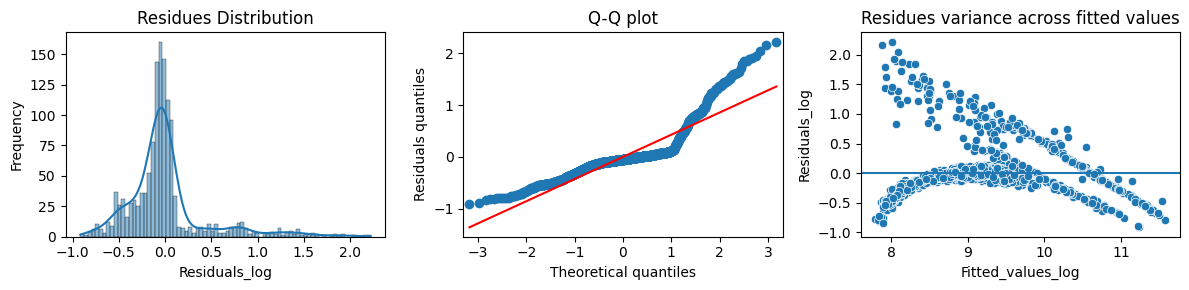

In [21]:
# assess residues from the model
residues_interaction = model_interaction.resid
fitted_values_interaction = model_interaction.fittedvalues

fig, axes = plt.subplots(1, 3, figsize=(12, 3)) # Increased width for side-by-side

# use histogram to visualize distribution of residues - Residuals Normality
sns.histplot(x=residues_interaction, kde=True, ax=axes[0])
axes[0].set_title("Residues Distribution")
axes[0].set_xlabel("Residuals_log")
axes[0].set_ylabel("Frequency")

# use Q-Q plot to visualize distribution of residues - Residuals Normality
sm.qqplot(residues_interaction, line = 's', ax=axes[1])
axes[1].set_title("Q-Q plot")
axes[1].set_xlabel("Theoretical quantiles")
axes[1].set_ylabel("Residuals quantiles")

# use scatterplot to visualize variance of residue across fitted_values - Residuals Homoscedasticity
sns.scatterplot(x = fitted_values_interaction, y=residues_interaction, ax=axes[2])
axes[2].set_title("Residues variance across fitted values")
axes[2].set_xlabel("Fitted_values_log")
axes[2].set_ylabel("Residuals_log")
axes[2].axhline(0)

plt.tight_layout()
plt.show()

### 3.6 Addressing the non-linear term

Final model with both interaction and polynomial terms, assuming a non-linear relationship between age and charges

In [22]:
ols_formula_final = "log_charges ~ age + I(age**2) + children + C(sex) + C(region) + bmi * C(smoker)"
model_final = ols(formula = ols_formula_final, data=data).fit()
model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_charges   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     485.3
Date:                Wed, 09 Jul 2025   Prob (F-statistic):               0.00
Time:                        10:12:50   Log-Likelihood:                -756.59
No. Observations:                1338   AIC:                             1535.
Df Residuals:                    1327   BIC:                             1592.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7.0168      0.124     56.752      0.000       6.774       7.259
C(sex)[T.male]            -0.0867      0.024     -3.685      0.000      -0.133      -0.041
C(region)[T.northwest]    -0.0703      0.034     -2.090      0.037      -0.136      -0.004
C(region)[T.southeast]    -0.1630      0.034     -4.824      0.000      -0.229      -0.097
C(region)[T.southwest]    -0.1377      0.034     -4.082      0.000      -0.204      -0.072
C(smoker)[T.yes]           0.1518      0.145      1.044      0.297      -0.134       0.437
age                        0.0535      0.006      9.319      0.000       0.042       0.065
I(age ** 2)               -0.0002   7.17e-05     -3.298      0.001      -0.000   -9.57e-05
children                   0.0931      0.010      9.142      0.000       0.073       0.113
bmi                        0.0036      0.002      1.601      0.110      -0.001       0.008
bmi:C(smoker)[T.yes]       0.0457      0.005      9.836      0.000       0.037       0.055
==============================================================================
Omnibus:                      557.263   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2436.960
Skew:                           1.975   Prob(JB):                         0.00
Kurtosis:                       8.301   Cond. No.                     2.72e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3.7 Model Diagnostics of newmodel -  model_final

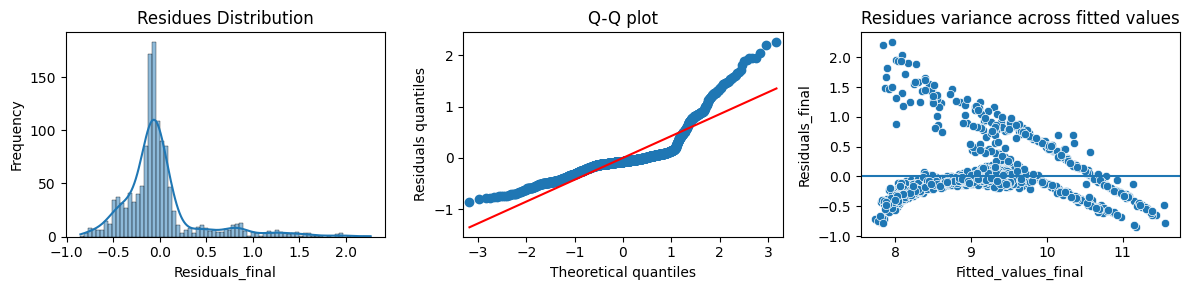

In [23]:
# assess residues from the model
residues_final = model_final.resid
fitted_values_final = model_final.fittedvalues

fig, axes = plt.subplots(1, 3, figsize=(12, 3)) # Increased width for side-by-side

# use histogram to visualize distribution of residues - Residuals Normality
sns.histplot(x=residues_final, kde=True, ax=axes[0])
axes[0].set_title("Residues Distribution")
axes[0].set_xlabel("Residuals_final")
axes[0].set_ylabel("Frequency")

# use Q-Q plot to visualize distribution of residues - Residuals Normality
sm.qqplot(residues_final, line = 's', ax=axes[1])
axes[1].set_title("Q-Q plot")
axes[1].set_xlabel("Theoretical quantiles")
axes[1].set_ylabel("Residuals quantiles")

# use scatterplot to visualize variance of residue across fitted_values - Residuals Homoscedasticity
sns.scatterplot(x = fitted_values_final, y=residues_final, ax=axes[2])
axes[2].set_title("Residues variance across fitted values")
axes[2].set_xlabel("Fitted_values_final")
axes[2].set_ylabel("Residuals_final")
axes[2].axhline(0)

plt.tight_layout()
plt.show()

### 3.8 Conclusion of "section 3"

The key drivers identified by the model are:

(1) Interaction between Smoking and BMI: The model shows that the impact of BMI on medical costs is heavily dependent on smoking status. The interaction term 

(2) bmi:C(smoker)[T.yes] is highly significant (p=0.000) with a coefficient of 0.0457.


(3) For a non-smoker, the effect of BMI is negligible, as its individual coefficient is not statistically significant (p=0.110).


(4) For a smoker, the effect of each additional BMI point corresponds to a charge increase of approximately 4.9% (0.36% from the bmi term + 4.57% from the interaction term).

(5) Non-Linear Effect of Age: The model confirms that the relationship between age and costs is not linear.

(6) The age coefficient is 0.0535, while the I(age**2) coefficient is -0.0002. Both are highly significant (p=0.000). This means that while charges increase with age, they do so at a decreasing rate.

(7) Children: The number of children is a significant predictor (p=0.000), with each additional child associated with an increase in log-charges by approximately 0.0931.

(8) Sex: Being male is associated with a decrease in log-charges of 0.0871 compared to being female, and this finding is statistically significant (p=0.000).

(9) Region: Compared to the Northeast region, living in the Southeast and Southwest is associated with a statistically significant decrease in charges, with coefficients of -0.1630 and -0.1375, respectively. Living in the Northwest is also associated with a significant, though smaller, decrease

### 4 Building Predictive Model

In [24]:
# import package from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [25]:
# define feature (X) and target (y)
X = data.drop(['charges', 'log_charges'], axis = 1)
y = data['log_charges']

# Implement a Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# create a combined taining data
train_data = pd.concat([X_train, y_train], axis = 1)

In [26]:
# perfrom ols model fitting for training dataset
final_model = ols(formula = "log_charges ~ age + I(age**2) + children + bmi + C(sex) + C(smoker) + C(region)", data = train_data).fit()

log_prediction = final_model.predict(X_test)      # prediction of y value based on x_test
prediction = np.exp(log_prediction)               # take exp to make predicted log_charge to charge
actual = np.exp(y_test)                           # take exp to make y_test in log to y_test without log

In [27]:
# evaluate the predicted result
mae = mean_absolute_error(actual, prediction)
mse = mean_squared_error(actual, prediction)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 3835.5727503833
Mean Squared Error (MSE): 56034456.07397297
Root Mean Squared Error (RMSE): 7485.616612809727


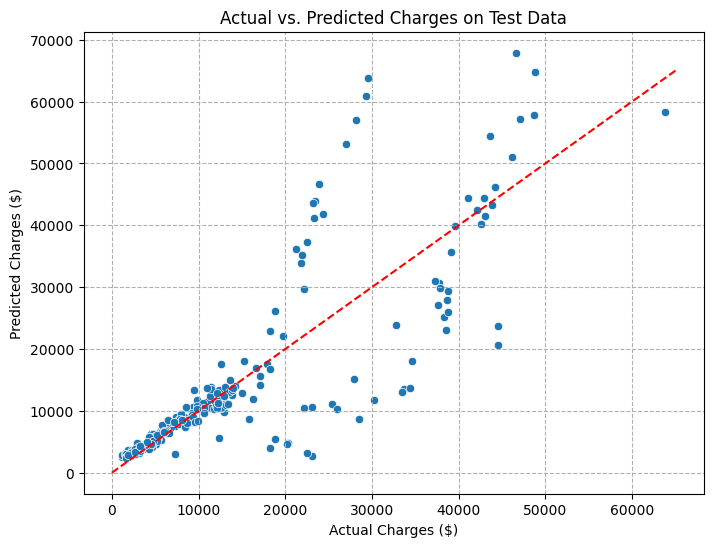

In [28]:
# Create a scatter plot of actual vs. predicted charges
plt.figure(figsize=(8, 6))
sns.scatterplot(x=actual, y=prediction)
plt.plot([0, 65000], [0, 65000], 'r--')    # Add a diagonal line for reference
plt.title('Actual vs. Predicted Charges on Test Data')
plt.xlabel('Actual Charges ($)')
plt.ylabel('Predicted Charges ($)')
plt.grid(True, which="both", ls="--")
plt.show()

### 4.1 Diagnostics of final model

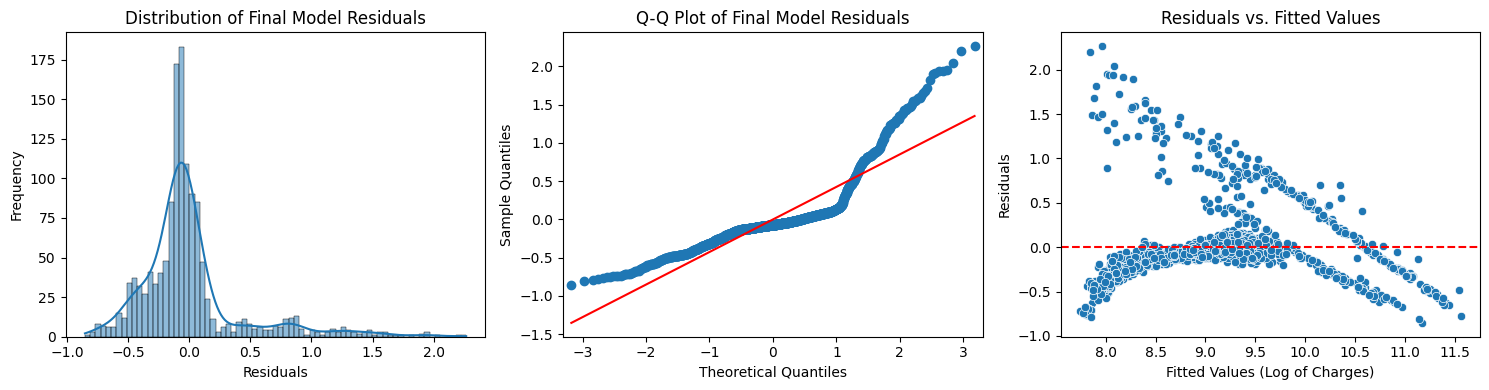

In [29]:
# --- Model Diagnostics for the Final Model ---

# Get residuals and fitted values from your final model
residues_final = model_final.resid
fitted_values_final = model_final.fittedvalues

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Histogram of residuals (for Normality check)
sns.histplot(x=residues_final, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Final Model Residuals")
axes[0].set_xlabel("Residuals")
axes[0].set_ylabel("Frequency")

# Plot 2: Q-Q plot (for Normality check)
sm.qqplot(residues_final, line='s', ax=axes[1])
axes[1].set_title("Q-Q Plot of Final Model Residuals")
axes[1].set_xlabel("Theoretical Quantiles")
axes[1].set_ylabel("Sample Quantiles")

# Plot 3: Residuals vs. Fitted values (for Homoscedasticity check)
sns.scatterplot(x=fitted_values_final, y=residues_final, ax=axes[2])
axes[2].axhline(0, color='r', linestyle='--')
axes[2].set_title("Residuals vs. Fitted Values")
axes[2].set_xlabel("Fitted Values (Log of Charges)")
axes[2].set_ylabel("Residuals")

plt.tight_layout()
plt.show()

### 4.2 Visualization Predictive Model

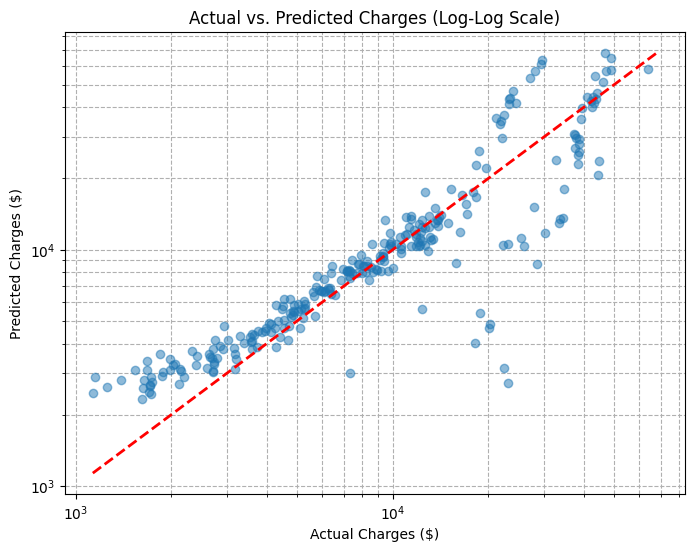

In [30]:
# --- Actual vs. Predicted Charges on a Log-Log Scale ---

plt.figure(figsize=(8, 6))

# Create a scatter plot with log scales for both axes
plt.loglog(actual, prediction, 'o', alpha=0.5)

# Add a diagonal reference line (y=x)
# Create a range for the line based on the min/max of your data
min_val = min(actual.min(), prediction.min())
max_val = max(actual.max(), prediction.max())
plt.loglog([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

plt.title('Actual vs. Predicted Charges (Log-Log Scale)')
plt.xlabel('Actual Charges ($)')
plt.ylabel('Predicted Charges ($)')
plt.grid(True, which="both", ls="--")
plt.show()

### 5. Using Scikit-Learn for pipeline model building (Alternative Method)

This section is another attempt for model building with scikit learn, practicing with pipeline model building

Pipeline(steps = [(step1),(step2),(step3)... ]) 

A pipeline automates the entire workflow of a machine learning model. Raw data enters at the beginning, and a trained model or a prediction comes out at the end. Each step in the pipeline is a distinct data processing task

In [31]:
# import packages from sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge 
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [32]:
# define featuwre X and target y
X = data.drop(['charges', 'log_charges'], axis = 1)
y = data['log_charges']

In [33]:
# prepare train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [34]:
# define categorial and numeric featuwres
categorial_features = ['sex', 'region', 'smoker']
numerical_features = ['children', 'bmi', 'age']

In [35]:
# creating processor for different data types

# processor for numeric variables: (1) scaling (2) polynimial / interaction
numeric_transformer = Pipeline(steps = [('scalar', StandardScaler()), ('poly', PolynomialFeatures(degree = 2, include_bias=False))])

# processor for categorial variables: (1) one-hot encoding
categorial_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

# Bundle preprocesser for all data types (combine two transformers above)
preprocesser = ColumnTransformer(transformers = [('num', numeric_transformer, numerical_features), ('cat', categorial_transformer, categorial_features)])

### 5.1 Building and training model with pipeliens using Ridge Regression

In [36]:
# Create the full pipeline with Ridge Regression
ridge_pipeline = Pipeline(steps = [('preprocesser', preprocesser), ('regresser', Ridge(random_state = 42))])

In [37]:
# train the pipeline
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['children', 'bmi', 'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'region',
                                                   'smoker'])])),
                ('regresser', Ridge(random_state=42))])

In [38]:
# Make predictions on the test set
log_prediction_pipe = ridge_pipeline.predict(X_test)

# Since the model predicts the log of charges, we need to convert it back
prediction_pipe = np.exp(log_prediction_pipe)
actual_pipe = np.exp(y_test)

# Evaluate the model
mae_pipe = mean_absolute_error(actual_pipe, prediction_pipe)
mse_pipe = mean_squared_error(actual_pipe, prediction_pipe)
rmse_pipe = np.sqrt(mse_pipe)

print(f"Mean Absolute Error (MAE): {mae_pipe}")
print(f"Mean Squared Error (MSE): {mse_pipe}")
print(f"Root Mean Squared Error (RMSE): {rmse_pipe}")

Mean Absolute Error (MAE): 3979.4815323779735
Mean Squared Error (MSE): 65209916.879189886
Root Mean Squared Error (RMSE): 8075.265746660594


### 5.2 Visualize Predicted Model

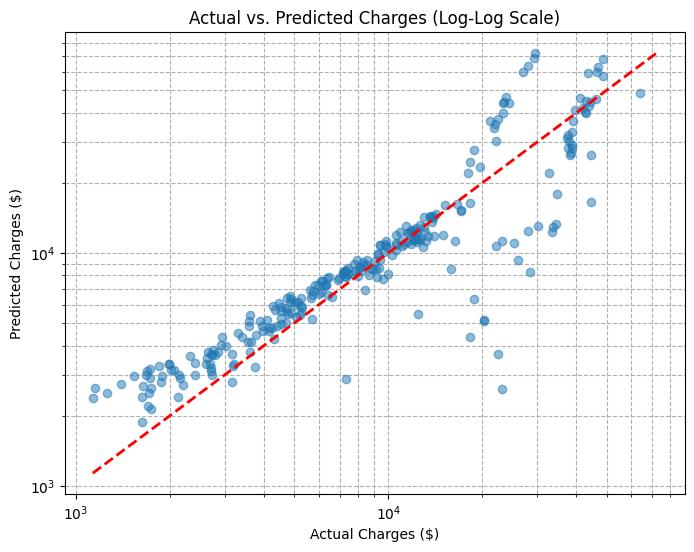

In [39]:
# --- Actual vs. Predicted Charges on a Log-Log Scale ---

plt.figure(figsize=(8, 6))

# Create a scatter plot with log scales for both axes
plt.loglog(actual_pipe, prediction_pipe, 'o', alpha=0.5)

# Add a diagonal reference line (y=x)
# Create a range for the line based on the min/max of your data
min_val = min(actual_pipe.min(), prediction_pipe.min())
max_val = max(actual_pipe.max(), prediction_pipe.max())
plt.loglog([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

plt.title('Actual vs. Predicted Charges (Log-Log Scale)')
plt.xlabel('Actual Charges ($)')
plt.ylabel('Predicted Charges ($)')
plt.grid(True, which="both", ls="--")
plt.show()

### 5.3 Section Summary

This section successfully rebuilds the predictive model using a more robust and streamlined Scikit-learn Pipeline. This approach automates the entire workflow, from data preprocessing to final model training, ensuring that the same steps are consistently applied to both training and new data. 

### 6. Project Conclusion

This project aimed to understand the key drivers of medical insurance charges and to build a predictive model based on those factors. Through a process of exploratory data analysis, hypothesis testing, and iterative model refinement, several significant insights were uncovered, leading to the development of a robust predictive model.

1. Key Analytical Findings:

    (1) Smoking as the Primary Driver: Both exploratory analysis and hypothesis testing confirmed that smoking status is the most significant factor influencing medical charges. Smokers consistently face substantially higher costs than non-smokers.
    
    (2) Interaction between BMI and Smoking: The analysis revealed a critical interaction effect. The impact of a high Body Mass Index (BMI) on medical costs is significantly more severe for smokers. For non-smokers, the effect of BMI alone was not statistically significant.
    
    (3) Non-Linear Effect of Age: Medical charges increase with age, but they do so at a decreasing rate, indicating a non-linear relationship that was best captured by including a squared term for age in the final model.
    
    (4) Other Significant Factors: The number of children, sex, and geographic region were also found to be statistically significant predictors of medical costs.

2. Modeling Process & Performance:

    (1) A multiple linear regression model was developed iteratively. A baseline model revealed violations of OLS assumptions (non-normality of residuals and heteroscedasticity), which were successfully addressed by applying a log transformation to the charges variable.
    
    (2) The model's predictive power was further improved by incorporating the BMI-smoker interaction term and a polynomial term for age, which were identified during EDA and model diagnostics.
    
    (3) The final model explained approximately 78.4% of the variance in the log of charges (Adj. R-squared: 0.784) and achieved the following performance on the unseen test data:
    
    (4) Root Mean Squared Error (RMSE): $7,485.62
    
    (5) Mean Absolute Error (MAE): $3,835.57
    
    (6) This indicates that, on average, the model's predictions are off by about $3,836. The RMSE is higher, which is expected given that it penalizes larger errors more heavily. The "Actual vs. Predicted" plot confirms that the model performs well across a wide range of charge values.

3. Final Comments:

    This analysis provides a strong foundation for predicting insurance costs. For an insurance provider, this model could be used to better assess risk profiles. The findings strongly suggest that wellness programs focused on smoking cessation and BMI management could be highly effective at reducing healthcare expenditures.